In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import csv
import sqlite3
from pprint import pprint

# im being really lazy here, just want to get something working
%env OPENAI_API_KEY=this-doesnt-matter

from sqlite_helper import sqlitefile_to_dataframe


env: OPENAI_API_KEY=this-doesnt-matter
parentdir /Users/gbolet/hecbench-roofline/qdecomp-langgraph-studio/kernel-survey/dataset-gen/manual-classification
dataset_path /Users/gbolet/hecbench-roofline/qdecomp-langgraph-studio/kernel-survey/dataset-gen/manual-classification/kernels_to_inference_balanced_with_compile_commands.csv
Azure model could not be setup correctly! Falling back to OpenAI model in its place.
Error: Missing credentials. Please pass one of `api_key`, `azure_ad_token`, `azure_ad_token_provider`, or the `AZURE_OPENAI_API_KEY` or `AZURE_OPENAI_AD_TOKEN` environment variables.


# Baseline Experiments Results Visualization

In [2]:
db_dir = './checkpoints/'

# get all the sqlite files in the db_dir
sqlite_files = [f for f in os.listdir(db_dir) if f.endswith('.sqlite')]

for sqlite_file in sqlite_files:
    print(f"Processing [{sqlite_file}]") 


# keep only the ones with gpt-5-mini in the name
sqlite_files = [f for f in sqlite_files if 'gpt-5-mini' in f]

print(sqlite_files)

Processing [openai-gpt-5-mini:simplePrompt:openrouter.sqlite]
['openai-gpt-5-mini:simplePrompt:openrouter.sqlite']


In [3]:
df = pd.DataFrame()

for sqlite_file in sqlite_files:
    full_path = os.path.join(db_dir, sqlite_file)

    filedf = sqlitefile_to_dataframe(full_path)

    df = pd.concat([df, filedf], ignore_index=True)



In [4]:
print(df.columns)

print(df.head(10))
print(f'DF Size: {df.shape}')

# print the df datatypes
# print(df.dtypes)

print(df.error.value_counts( dropna=False ))

Index(['combined_name', 'model_name', 'provider', 'trial_number',
       'prompt_type', 'variant_type', 'nnz_flop_state', 'top_p', 'temp',
       'langgraph_thread_id', 'source_code', 'kernel_name', 'exec_args',
       'grid_size', 'block_size', 'total_num_threads', 'compile_commands',
       'empirical_sp_flop_count', 'empirical_dp_flop_count', 'raw_flop_counts',
       'predicted_sp_flop_count', 'predicted_dp_flop_count',
       'predicted_sp_flop_count_explanation',
       'predicted_dp_flop_count_explanation', 'input_tokens', 'output_tokens',
       'total_cost', 'total_query_time', 'error', 'state_of_failure',
       'generic_model_name', 'has_nz_flops', 'percent_diff_sp',
       'percent_diff_dp'],
      dtype='object')
                                 combined_name         model_name  \
0                      (bh-cuda, ClearKernel1)  openai/gpt-5-mini   
1                      (bh-cuda, ClearKernel2)  openai/gpt-5-mini   
2                 (dct8x8-cuda, DCT8x8_kernel)  openai/gp

## Adjust some of the columns

In [5]:
# now we want to plot the prediction accuracy vs. the ground truth for each generic_model_name and prompt_type

def plot_predictions_for_model_name(df, model_name='gpt-5-mini', prompt_type='simple'):
    sub_df = df[(df['generic_model_name'] == model_name) & (df['prompt_type'] == prompt_type)]
    success_df = sub_df[(sub_df['error'] == 'Success')]

    print(f'Success DF Size: {success_df.shape}')
    fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)

    max_sp_dp_flop = max(
        success_df['empirical_sp_flop_count'].max(),
        success_df['empirical_dp_flop_count'].max(),
        success_df['predicted_sp_flop_count'].max(),
        success_df['predicted_dp_flop_count'].max()
    )
    min_sp_dp_flop = min(
        success_df['empirical_sp_flop_count'].min(),
        success_df['empirical_dp_flop_count'].min(),
        success_df['predicted_sp_flop_count'].min(),
        success_df['predicted_dp_flop_count'].min()
    )

    # plot the x-y line on the plot
    ax.plot([min_sp_dp_flop, max_sp_dp_flop], [min_sp_dp_flop, max_sp_dp_flop], color='red', linestyle='--', alpha=0.5, label='perfect prediction')

    sns.scatterplot(x='empirical_sp_flop_count', y='predicted_sp_flop_count', data=success_df, label='SP FLOP', alpha=0.5, ax=ax, color='orange')
    sns.scatterplot(x='empirical_dp_flop_count', y='predicted_dp_flop_count', data=success_df, label='DP FLOP', alpha=0.5, ax=ax, color='blue')

    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

    ax.set_title(f'Baseline: LLM-Predicted vs Actual FLOP Counts \n({model_name} -- {prompt_type} prompt)')

    ax.set_xlabel('Actual/Profiled FLOP Count')
    ax.set_ylabel('LLM-Predicted FLOP Count')
    # change x ticks font size
    ax.tick_params(axis='x', labelsize=6)
    # adjust the legend font size to be smaller
    ax.legend(fontsize=6)

    # put the legend outside the plot
    ax.legend(bbox_to_anchor=(1.01, 0.65), loc='upper left', fontsize=6)

    plt.tight_layout()
    plt.show()

    ##############################################
    # let's print the CDF of the percent differences for SP and DP FLOP counts

    nnz_sp_data = success_df['percent_diff_sp']
    nnz_dp_data = success_df['percent_diff_dp']

    # let's make a cdf plot
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)

    sns.ecdfplot(nnz_sp_data, label='SP FLOP', ax=ax, color='orange')
    sns.ecdfplot(nnz_dp_data, label='DP FLOP', ax=ax, color='blue')

    ax.set_xscale('symlog')
    #ax.set_yscale('log')
    ax.set_xlabel('Percent Difference (%)')
    ax.set_ylabel('Proportion of Data <= X')
    ax.legend()
    ax.set_title(f'CDF of Percent Differences \n({model_name} -- {prompt_type} prompt)')

    plt.tight_layout()
    plt.show()

    # let's make histograms of the total_cost, totalQueryTime, and failure cases
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=200)

    sns.histplot(data=success_df, x='total_cost', hue='has_nz_flops', bins=50, ax=axs[0])
    axs[0].set_title('Query Cost Distribution')
    axs[0].set_xlabel('Query Cost ($ USD)')
    axs[0].set_ylabel('Frequency')
    axs[0].get_legend().set_title('Kernel has NZ FLOPs?')

    # rotate the x ticks for the query cost plot
    for label in axs[0].get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')


    sns.histplot(data=success_df, x='total_query_time', hue='has_nz_flops', bins=50, ax=axs[1])
    axs[1].set_title('Total Query Time Distribution')
    axs[1].set_xlabel('Total Query Time (seconds)')
    axs[1].set_ylabel('Frequency')
    axs[1].get_legend().set_title('Kernel has NZ FLOPs?')

    #error_value_counts = df['error'].value_counts()
    sns.countplot(data=sub_df, x='error', ax=axs[2])
    axs[2].set_title('Failure Cases Distribution')
    axs[2].set_xlabel('Failure Cases')
    axs[2].set_ylabel('Frequency')

    # add countplot values on top of the bars
    for p in axs[2].patches:
        axs[2].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')

    plt.tight_layout()
    plt.show()

    ##############################################
    percents = [1, 5, 10, 50, 100]
    for perc in percents:
        num_sp_within_xpct = ((nnz_sp_data > -perc) & (nnz_sp_data < perc)).sum()
        num_sp_outside_xpct = ((nnz_sp_data <= -perc) | (nnz_sp_data >= perc)).sum()

        num_dp_within_xpct = ((nnz_dp_data > -perc) & (nnz_dp_data < perc)).sum()
        num_dp_outside_xpct = ((nnz_dp_data <= -perc) | (nnz_dp_data >= perc)).sum()

        total_sp = nnz_sp_data.shape[0]
        total_dp = nnz_dp_data.shape[0]

        print(f'SP FLOP: {num_sp_within_xpct} / {total_sp} ({100*num_sp_within_xpct/total_sp:.2f}%) within +/- {perc}%')
        print(f'SP FLOP: {num_sp_outside_xpct} / {total_sp} ({100*num_sp_outside_xpct/total_sp:.2f}%) outside +/- {perc}%')
        print(f'DP FLOP: {num_dp_within_xpct} / {total_dp} ({100*num_dp_within_xpct/total_dp:.2f}%) within +/- {perc}%')
        print(f'DP FLOP: {num_dp_outside_xpct} / {total_dp} ({100*num_dp_outside_xpct/total_dp:.2f}%) outside +/- {perc}%')
        print("\n")

    print("\n")

    # let's look at the cases that are 100% outside
    outliers = success_df[( (success_df['percent_diff_sp'] <= -100) | (success_df['percent_diff_sp'] >= 100) |
                            (success_df['percent_diff_dp'] <= -100) | (success_df['percent_diff_dp'] >= 100) )]
    print(f'Outliers (>=100% error): {outliers.shape[0]}')

    for index, row in outliers.iterrows():
        print(f"Combined Name: {row['combined_name']}")
        print(f"Variant Type: {row['variant_type']}")
        print(f"Prompt Type: {row['prompt_type']}")
        print(f"NNZ FLOP State: {row['nnz_flop_state']}")
        print(f"Trial Number: {row['trial_number']}")
        print(f'Execution Args: {row["exec_args"]}')
        print(f'Token Usage: Input={row["input_tokens"]}, Output={row["output_tokens"]}')
        print(f'Total Query Time: {row["total_query_time"]} seconds')
        print(f'Total Cost: ${row["total_cost"]}')
        print()
        print(f"  SP FLOP: Predicted={row['predicted_sp_flop_count']}, Actual={row['empirical_sp_flop_count']}, Percent Diff={row['percent_diff_sp']:.2f}%")
        print(f"  SP FLOP Explanation: {row['predicted_sp_flop_count_explanation']}")
        print()
        print(f"  DP FLOP: Predicted={row['predicted_dp_flop_count']}, Actual={row['empirical_dp_flop_count']}, Percent Diff={row['percent_diff_dp']:.2f}%")
        print(f"  DP FLOP Explanation: {row['predicted_dp_flop_count_explanation']}")
        print("--------------------------------------------------\n")

    ##############################################



    return


Success DF Size: (5, 34)


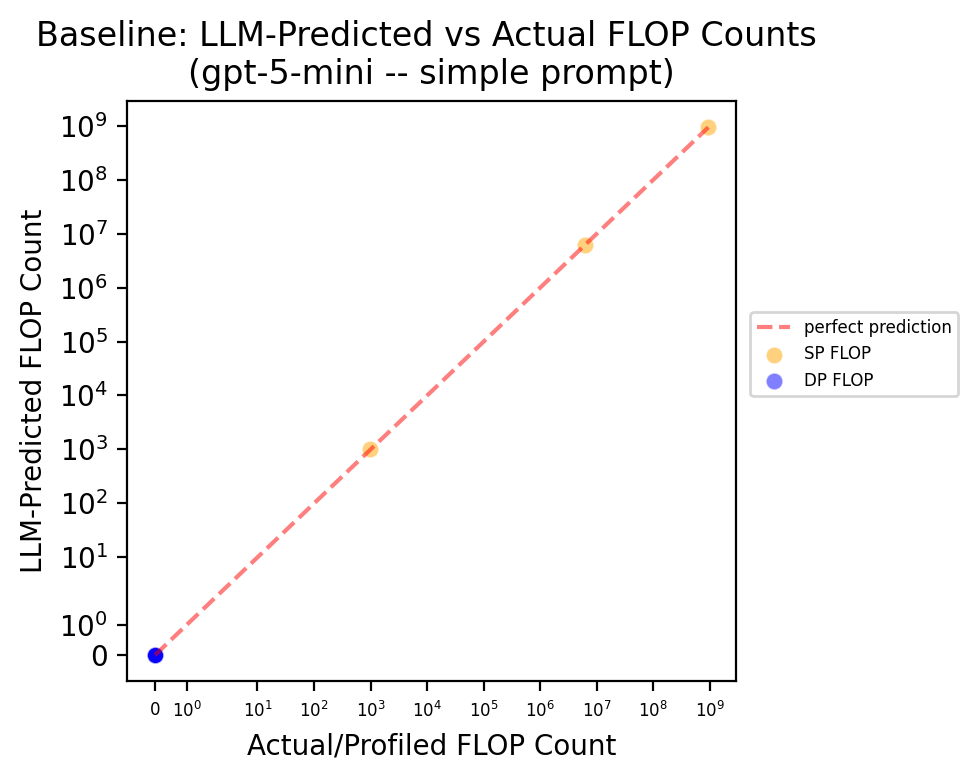

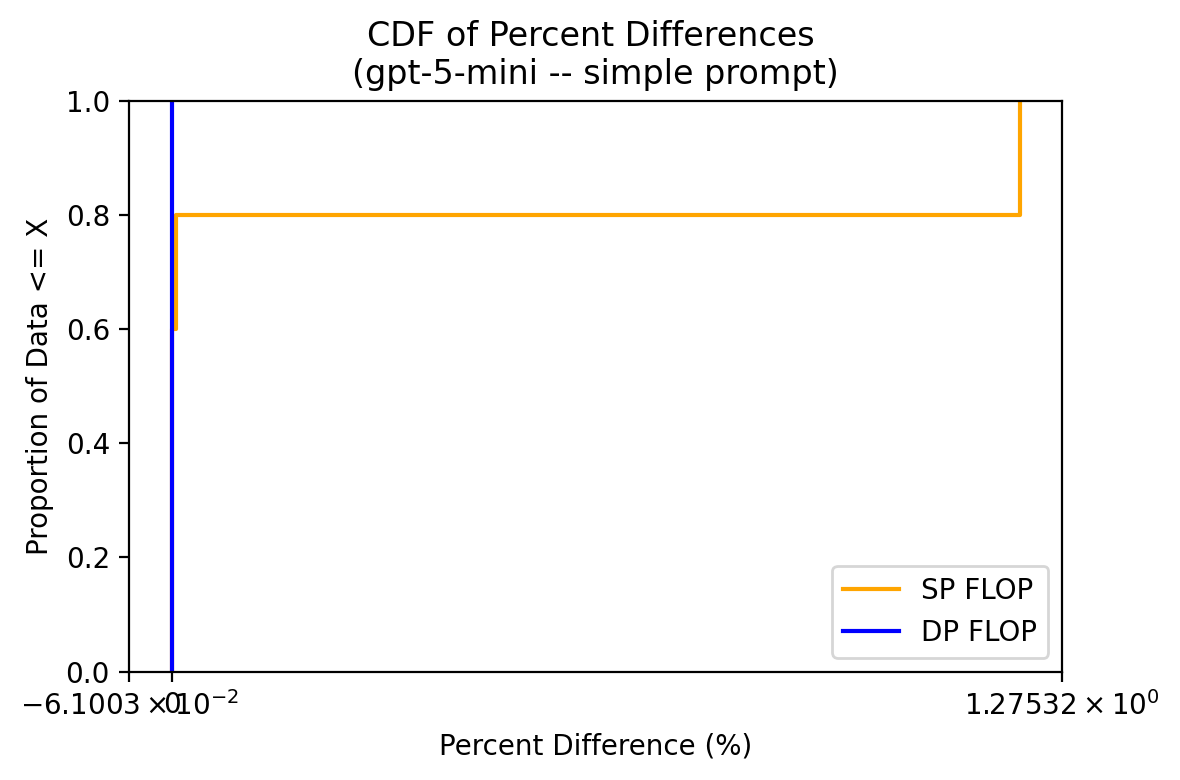

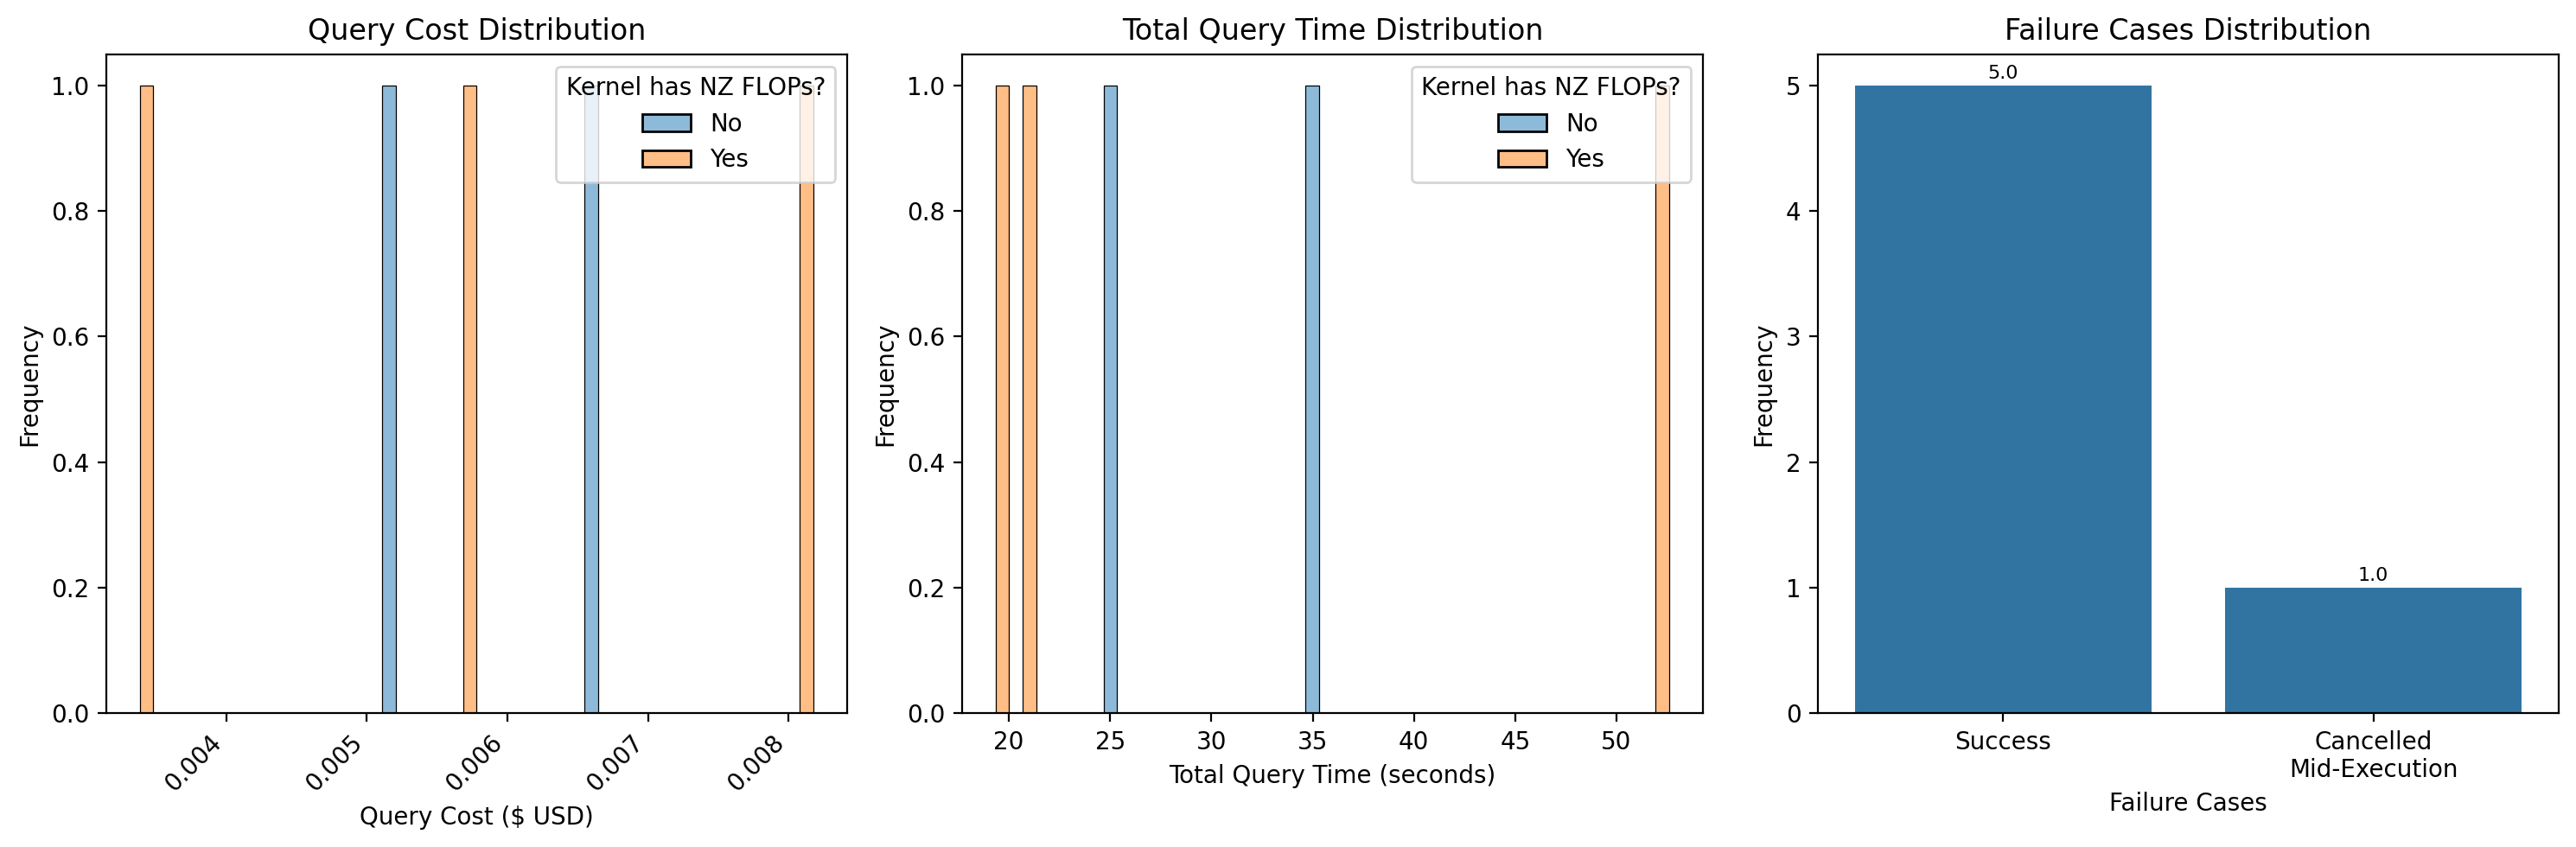

SP FLOP: 4 / 5 (80.00%) within +/- 1%
SP FLOP: 1 / 5 (20.00%) outside +/- 1%
DP FLOP: 5 / 5 (100.00%) within +/- 1%
DP FLOP: 0 / 5 (0.00%) outside +/- 1%


SP FLOP: 5 / 5 (100.00%) within +/- 5%
SP FLOP: 0 / 5 (0.00%) outside +/- 5%
DP FLOP: 5 / 5 (100.00%) within +/- 5%
DP FLOP: 0 / 5 (0.00%) outside +/- 5%


SP FLOP: 5 / 5 (100.00%) within +/- 10%
SP FLOP: 0 / 5 (0.00%) outside +/- 10%
DP FLOP: 5 / 5 (100.00%) within +/- 10%
DP FLOP: 0 / 5 (0.00%) outside +/- 10%


SP FLOP: 5 / 5 (100.00%) within +/- 50%
SP FLOP: 0 / 5 (0.00%) outside +/- 50%
DP FLOP: 5 / 5 (100.00%) within +/- 50%
DP FLOP: 0 / 5 (0.00%) outside +/- 50%


SP FLOP: 5 / 5 (100.00%) within +/- 100%
SP FLOP: 0 / 5 (0.00%) outside +/- 100%
DP FLOP: 5 / 5 (100.00%) within +/- 100%
DP FLOP: 0 / 5 (0.00%) outside +/- 100%




Outliers (>=100% error): 0
Success DF Size: (0, 34)


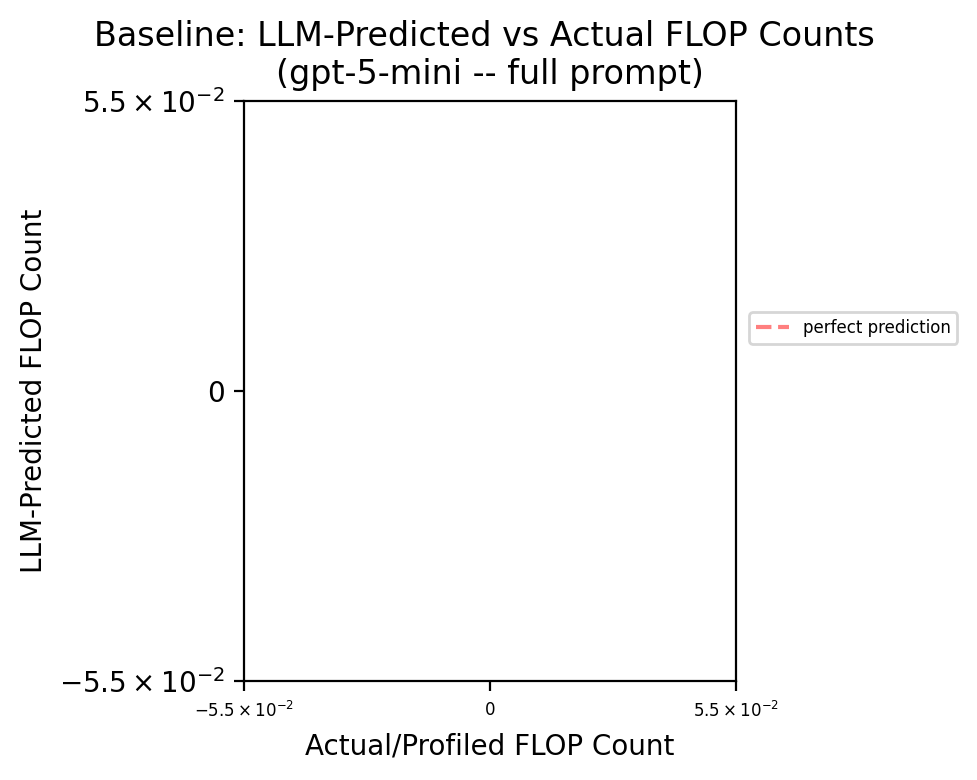

/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_47205/227422296.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


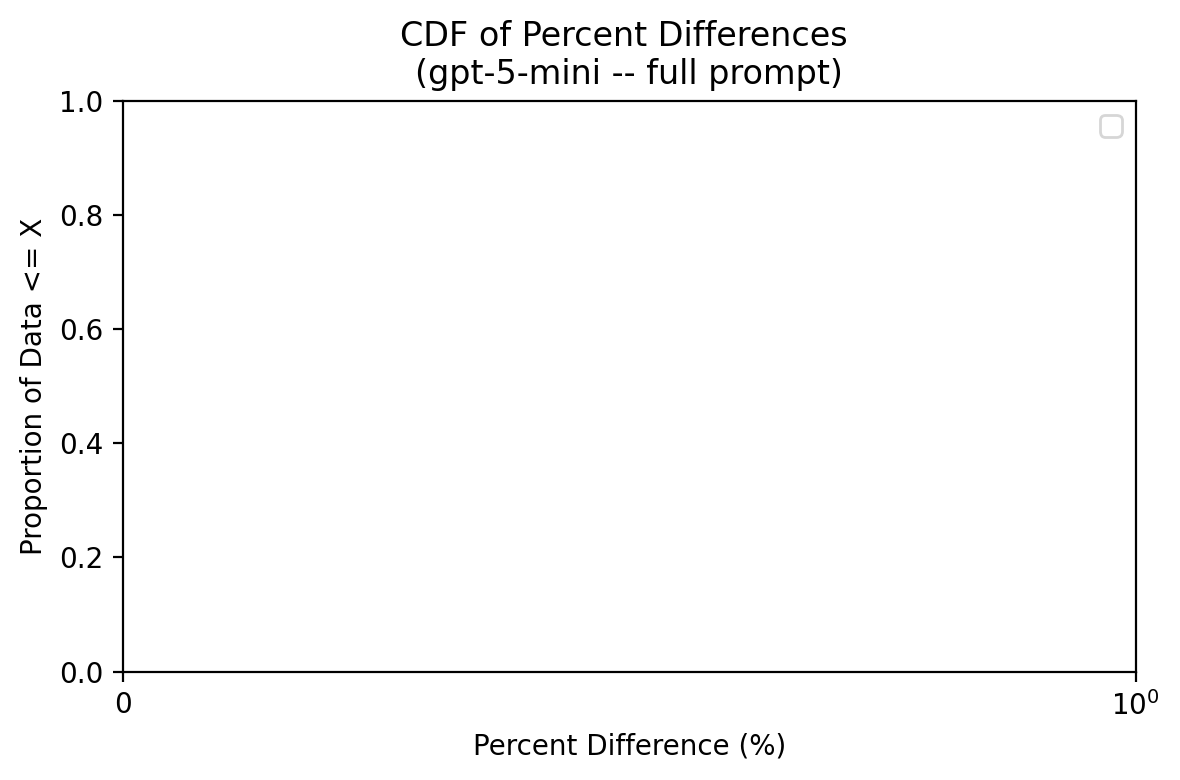

ValueError: No objects to concatenate

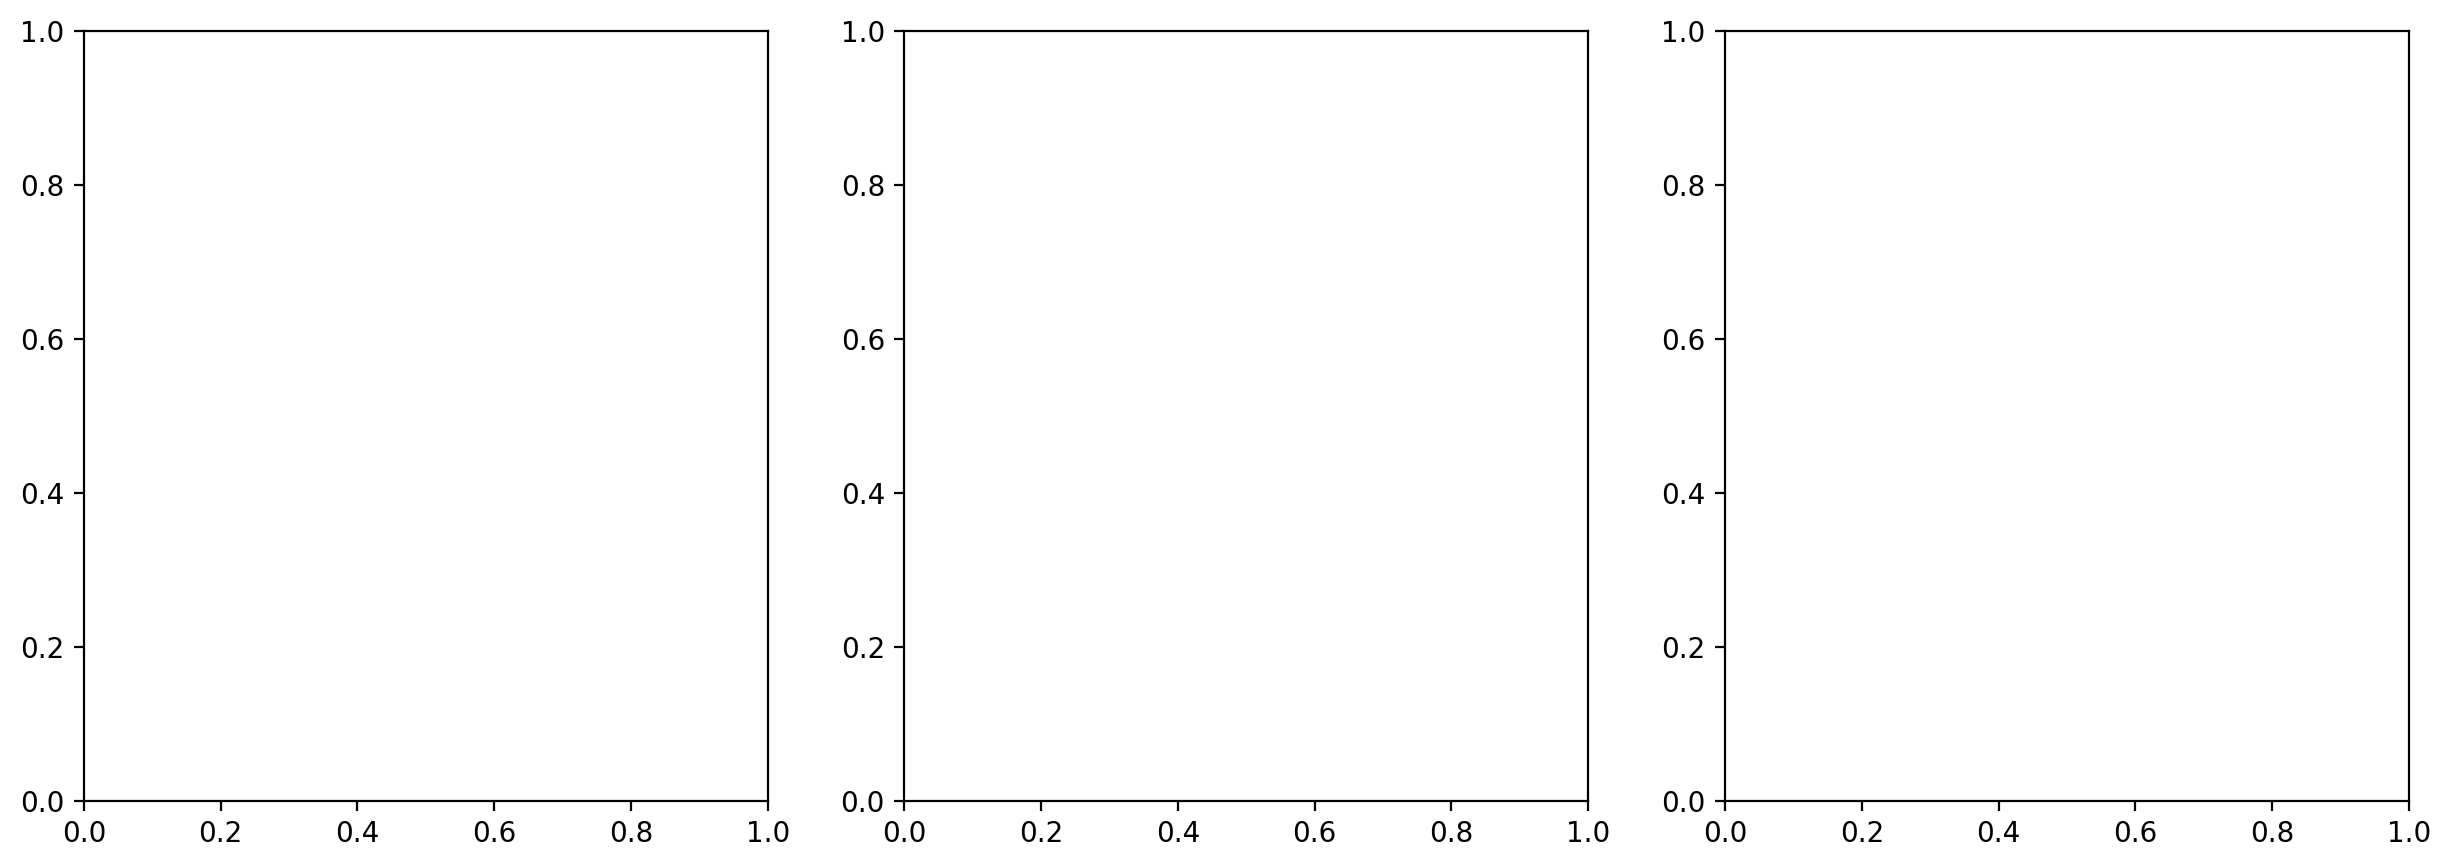

In [ ]:
plot_predictions_for_model_name(df, 'gpt-5-mini', 'simple')
plot_predictions_for_model_name(df, 'gpt-5-mini', 'full')